In [1]:
import os
import csv

from PIL import Image as im

import torch
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import transforms

import pytorch_lightning as pl

In [2]:
class PLDataModule(pl.LightningDataModule):
    def __init__(self, data_root, img_size, batch_size=32, train_split=0.8):
        self.root = data_root
        self.metadata = self.get_metadata()
        self.img_size = img_size
        self.batch_size = batch_size
        self.train_split = train_split
        self.train_mean = [0.0, 0., 0.0]
        self.train_std = [1.0, 1.0, 1.0]
        self.common_transforms = transforms.Compose([
            transforms.Resize((img_size + 20, img_size + 20), 
                              transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            
        ])
        
    
    def prepare_data(self):
        # There is nothing to prepare.
        # The data should have already been downloaded and
        # extracted in the data_root that is passed to initiaize this class
        pass
    
    def setup(self, stage='fit'):
        data_dict = self.get_img_path_labels(stage)
        imgs_ct = len(data_dict['image_path'])
        imgs_tensor = torch.empty([imgs_ct, 3, self.img_size, self.img_size])
        labels_tensor = torch.empty(imgs_ct)
        
        for i in range(imgs_ct):
            img = im.open(data_dict['image_path'][i]).convert("RGB")
            img = self.common_transforms(img)
            imgs_tensor[i] = img
            labels_tensor[i] = data_dict['label'][i]
        
        if stage == 'fit':
            self.mean, self.std = self.compute_mean_std(imgs_tensor)
            imgs_tensor = transforms.functional.normalize(imgs_tensor, self.mean, self.std)
            final_dataset = tuple(map(lambda x, y: (x, y,), imgs_tensor, labels_tensor))
            train_split = torch.ceil(torch.tensor(imgs_ct * self.train_split)).to(int).item()
            self.train_set, self.val_set = random_split(final_dataset, [train_split, imgs_ct-train_split])
        else:
            imgs_tensor = transforms.functional.normalize(imgs_tensor, self.mean, self.std)
            self.test_set = tuple(map(lambda x, y: (x, y), imgs_tensor, labels_tensor))
            
    
    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size)
    
    #############################
    ## Miscellaneous functions ##
    #############################
    def compute_mean_std(self, image_tensor):
        axes = (0,2,3)
        return image_tensor.mean(axis=axes), image_tensor.std(axis=axes)
        
    def get_img_path_labels(self, stage='fit'):
        data_dict = {'image_path':[], 'label':[]}
        if stage == 'fit':
            dir_ = os.path.join(self.root, 'training', 'training')
        else:
            dir_ = os.path.join(self.root, 'validation', 'validation')
            
        for cl in self.metadata['Label']:
            class_path = os.path.join(dir_, cl)
            for img in os.listdir(class_path):
                if img.endswith(".jpg") or img.endswith(".png"):
                    fname = os.path.join(class_path, img)
                    data_dict['image_path'].append(fname)
                    data_dict['label'].append(int(cl[1]))
        
        return data_dict

    
    def get_metadata(self):
        metadata = dict()
        with open(os.path.join(self.root, 'monkey_labels.txt'), mode ='r') as file:
            csvFile = csv.reader(file)            
            headers = [r.strip() for r in  next(csvFile)]
            
            for h in headers:
                metadata[h] = []
                
            for lines in csvFile:
                for i in range(len(lines)):
                    metadata[headers[i]].append(lines[i].strip())
        return metadata

In [3]:
d = PLDataModule('./../monkeys/', img_size=64, batch_size=20, train_split=0.85)

In [4]:
%%time
d.setup()

CPU times: user 41.5 s, sys: 1.67 s, total: 43.2 s
Wall time: 43 s


In [5]:
ds = d.train_dataloader()
dsi = iter(ds)

In [6]:
ds1 = next(dsi)
print(ds1[0].shape, ds1[1].shape)

torch.Size([20, 3, 64, 64]) torch.Size([20])


silvery_marmoset
mico_argentatus


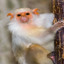

In [7]:
t = d.train_set
idx = torch.randint(0, 20, (1,)).item()
a, b = ds1
a = ((a[idx].permute(1,2,0) * d.std + d.mean) * 255).clamp(0, 255).to(torch.uint8).numpy()
print(d.metadata['Common Name'][int(b[idx])])
print(d.metadata['Latin Name'][int(b[idx])])
im.fromarray(a)